## ENR - Elastic net regression

## import environment

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  
from sklearn.preprocessing import minmax_scale
%matplotlib inline
from scipy import stats
from datetime import datetime
import os

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from numpy import arange

import itertools 
from time import time
from functools import reduce 
import operator

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

#Seaborn
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

## Import model

In [2]:
from sklearn.linear_model import ElasticNet # Import model

# Reading Data

In [3]:
trainDf = pd.read_csv ("data/ML-CUP20-TR.csv")

# Normalize
colnames=trainDf.columns.values
trainDf=pd.DataFrame(minmax_scale(trainDf, feature_range=(0,1), axis=0))
trainDf.columns=colnames
trainDf.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y1,Y2
count,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000
mean,0.493986,0.455558,0.422902,0.532771,0.542641,0.556990,0.448495,0.479733,0.477938,0.494039,0.425603,0.351685
std,0.229482,0.218699,0.211772,0.174884,0.209266,0.168283,0.216930,0.206977,0.214500,0.224177,0.287916,0.271691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.277706,0.261214,0.236137,0.407235,0.353918,0.448039,0.244393,0.305093,0.281794,0.286610,0.164375,0.130400
50%,0.515967,0.464428,0.416107,0.527146,0.576631,0.533931,0.475399,0.480954,0.482409,0.536919,0.366169,0.296888
75%,0.686938,0.638466,0.584685,0.648318,0.715638,0.665114,0.635441,0.637042,0.659932,0.668569,0.672862,0.502768
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Full dataset

In [4]:
dataset=trainDf.values
Xtot = dataset[:, 0:10]
Ytot = dataset[:, 10:12]
ytot = dataset[:, 10]

## Split dataset 60%

In [5]:
first_split = trainDf.sample(frac=0.6,random_state=200)
second_split=trainDf.drop(first_split.index)
trainset = first_split.to_numpy()
testset = second_split.to_numpy()


In [6]:
X = trainset[:, 0:10]
Y = trainset[:, 10:12]  # Y1 and Y2 train
y = trainset[:, 10]     # Y1 train
yb = trainset[:, 11]    # Y2 

Xtest= dataset[:, 0:10]
Ytest = dataset[:, 10:12] # Y1 and Y2 test
ytest= dataset[:, 10]     # Y1 test
ybtest= dataset[:, 11]    # Y2 test

## MODEL DATA NEED TO CHANGE!

In [7]:
scoring='neg_mean_squared_error'
n_jobs=2
modelname="ENR (Elastic net Regressor)"

In [8]:
## Dont change this tab

In [9]:
gridsy1=[]
gridsy2=[]
result_list=[]

grid_dict = {}

gridindexcounter=0
def safe_arange(start, stop, step):
    return step * np.arange(start / step, stop / step)

In [10]:
# 'base_estimator__max_iter': [1, 10,50, 100,250, 500,750, 1000],
grid_params = [{
        'base_estimator__alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
            'base_estimator__l1_ratio': arange(0, 1, 0.01).tolist(),
            'base_estimator__max_iter': [1, 10,50, 100,250, 500,750, 1000],
            'base_estimator__fit_intercept': [True, False],
            'base_estimator__selection': ['cyclic', 'random']}]

print(grid_params)
pipe= Pipeline([('scl', StandardScaler()),
                 ('pca', PCA(n_components=2)),   
                 ('base_estimator', ElasticNet(alpha=1.0))])
		
gsY1 = GridSearchCV(estimator=pipe,
			param_grid=grid_params,
            n_jobs=n_jobs,
			scoring=scoring,
            cv=10,verbose=1)
gsY2 = GridSearchCV(estimator=pipe,
			param_grid=grid_params,
            n_jobs=n_jobs,
			scoring=scoring,
            cv=10,verbose=1)
gridsy1.append(gsY1)  
gridsy2.append(gsY2)  
grid_dict[gridindexcounter]=modelname
gridindexcounter+=1

[{'base_estimator__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0], 'base_estimator__l1_ratio': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99], 'base_estimator__max_iter': [1, 10, 50, 100, 250, 500, 750, 1000], 'base_estimator__fit_intercept': [True, False], 'base_estimator__selection': ['cycli

In [11]:
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''

for idx, gs in enumerate(gridsy1):
    start_time = timer(None) # timing starts from this point for "start_time" variable
    print('\nEstimator: %s' % grid_dict[idx])	
    # Fit grid search	
    grid_result=gs.fit(X, y)
    result_list.append(grid_result)
    timer(start_time) # timing ends here for "start_time" variable
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(Xtest)

    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % mean_squared_error(ytest, y_pred))
    # Track best (highest test accuracy) model

    if mean_squared_error(ytest, y_pred) > best_acc:
        best_acc = mean_squared_error(ytest, y_pred)
        best_gs = gs
        best_clf = idx
        
best_acc = 0.0
best_clf = 0
best_gs = ''

for idx, gs in enumerate(gridsy2):
    start_time = timer(None) # timing starts from this point for "start_time" variable
    print('\nEstimator: %s' % grid_dict[idx])	
    # Fit grid search	
    grid_result=gs.fit(X, yb)
    result_list.append(grid_result)
    timer(start_time) # timing ends here for "start_time" variable
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_predb = gs.predict(Xtest)

    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % mean_squared_error(ybtest, y_predb))
    # Track best (highest test accuracy) model

    if mean_squared_error(ybtest, y_predb) > best_acc:
        best_acc = mean_squared_error(ybtest, y_predb)
        best_gs = gs
        best_clf = idx

Performing model optimizations...

Estimator: ENR (Elastic net Regressor)
Fitting 10 folds for each of 28800 candidates, totalling 288000 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 270 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done 2670 tasks      | elapsed:   22.2s
[Parallel(n_jobs=2)]: Done 6670 tasks      | elapsed:   46.5s
[Parallel(n_jobs=2)]: Done 12270 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 19470 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 28270 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 38670 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done 50670 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 64270 tasks      | elapsed:  6.6min
[Parallel(n_jobs=2)]: Done 79470 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done 96270 tasks      | elapsed: 10.5min
[Parallel(n_jobs=2)]: Done 114670 tasks      | elapsed: 12.5min
[Parallel(n_jobs=2)]: Done 13

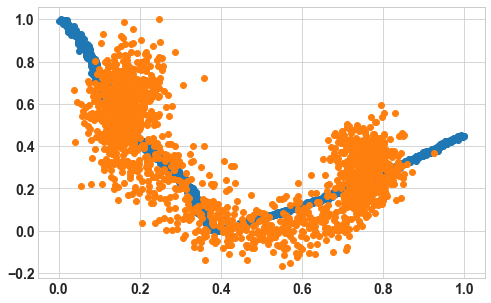

In [12]:
plt.scatter(ytest,ybtest)
plt.scatter(y_pred,y_predb)

In [16]:
print(best_gs.best_params_)

{'base_estimator__alpha': 0.01, 'base_estimator__fit_intercept': True, 'base_estimator__l1_ratio': 0.0, 'base_estimator__selection': 'cyclic'}
